In [5]:
import statsmodels.api as sm

In [6]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import pandas as pd
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.cm as cm
% matplotlib inline

nc_filename = sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))
nc_filename_= sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/*.csv'))
print("found *.csv file: \n{}".format(nc_filename_))



filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/*T200201-200712*.nc'))
ptrc=nc.Dataset(filename[0])
nav_lon=ptrc.variables['nav_lon'][:]
nav_lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

found *.csv file: 
['/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/1_ref5.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_1.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/60c.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/60c2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/60c3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/fi

In [8]:
#method 1: fit the total.. see what we get

Yellow      : 0.0401827442891 95.7064180342
Green: 0.101031206953 245.792959443


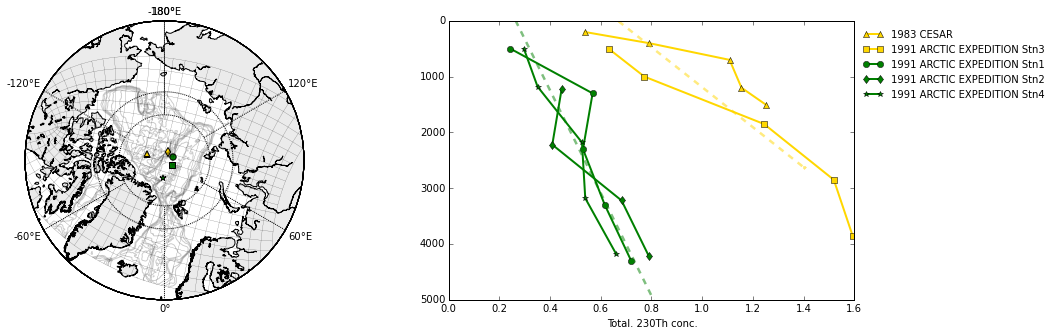

In [9]:
ax = plt.figure(1,figsize=(16,5))
ax = plt.subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round='True')
col=['gold','purple','purple','purple','purple','g','g','gold','g','purple','purple',\
     'yellowgreen','yellowgreen','yellowgreen']
mark=['^','s','o','d','*','H','D','>']

i=0
# 1983,1991

for j in ([0,5,6,7,8]):
    data=pd.read_csv(nc_filename_[j])
    lon = data['long.'];
    lat = data['lat.'];

    name= data['name'][0];  
    y_lon, yy_lat = m(lon[0], lat[0])
    m.scatter(y_lon,yy_lat,c=col[j],marker=mark[i],s=40,label=name)
    i+=1
        

#draw basemap
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[0, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,60.),labels=[1, 1, 1, 1])
x_lon, y_lat = m(nav_lon[:], nav_lat[:])
m.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='black',linewidth=0.2,alpha=0.7)
m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.2)


ax = plt.subplot(1,2,2)

i=0
##============================
#combine yellow stations
err_=[]
x_=[]
y_=[]

for j in ([0,7]):
    data=pd.read_csv(nc_filename_[j])
    if j==0:
        start=2
    else:
        start=1
    y= data['depth'][start:].values;
    x=data['230Th part.'][start:]+data['230Th diss.'][start:];

    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    x=x.compressed()
    y=y.compressed()
    name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,color=col[j],marker=mark[i],label=name)
    i+=1
    
    
    for num in range (len(x)):
        x_.append(x[num])
        y_.append(y[num])
        
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_)
x_=np.array(x_)
y_=np.array(y_)
mywls = sm.WLS(x_, y2).fit()
#mywls = sm.WLS(x_, y2, weights=1./err_**2).fit()#conc. depth
if j !=0:
    plt.plot([0, 1.4],[0, 1.4]/mywls.params[0]-mywls.params[1]/mywls.params[0], \
         '--.',c=col[j],linewidth=2.5,alpha=0.5)

a=mywls.params[0] #slope
b=mywls.params[1] #cons.  
Q= 0.0267
kd=0.5

k_=Q/a
s_=(kd/k_+1)*Q/b
print 'Yellow      :',s_ , k_


##============================
#combine green stations
err_=[]
x_=[]
y_=[]

for j in ([5,6,8]):
    data=pd.read_csv(nc_filename_[j])
    if j==8:
        start=1
    else:
        start=0
    y= data['depth'][start:].values;
    x=data['230Th part.'][start:]+data['230Th diss.'][start:];

    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    x=x.compressed()
    y=y.compressed()
    if j<12:
        name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,color=col[j],marker=mark[i],label=name)
    i+=1
    
    
    for num in range (len(x)):
        #err_.append(err[num])
        x_.append(x[num])
        y_.append(y[num])
        
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_)
x_=np.array(x_)
y_=np.array(y_)
mywls = sm.WLS(x_, y2).fit()
#mywls = sm.WLS(x_, y2, weights=1./err_**2).fit()#conc. depth
if j !=0:
    plt.plot([0, 1.4],[0, 1.4]/mywls.params[0]-mywls.params[1]/mywls.params[0], \
         '--.',c=col[j],linewidth=2.5,alpha=0.5)

a=mywls.params[0] #slope
b=mywls.params[1] #cons.  
Q= 0.0267
k__=Q/a
s__=(kd/k__+1)*Q/b
print 'Green:',s__, k__

plt.ylim(0,5000);plt.gca().invert_yaxis()
#label
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1),frameon=False)
plt.xlabel('Total. 230Th conc.');plt.show()

In [10]:
# sinking rate doesn't look good. Try method2...

#method2: calculate k using slopes

Yellow     : 528.70788586 176.235961953
Green      : 1041.92703109 347.309010362


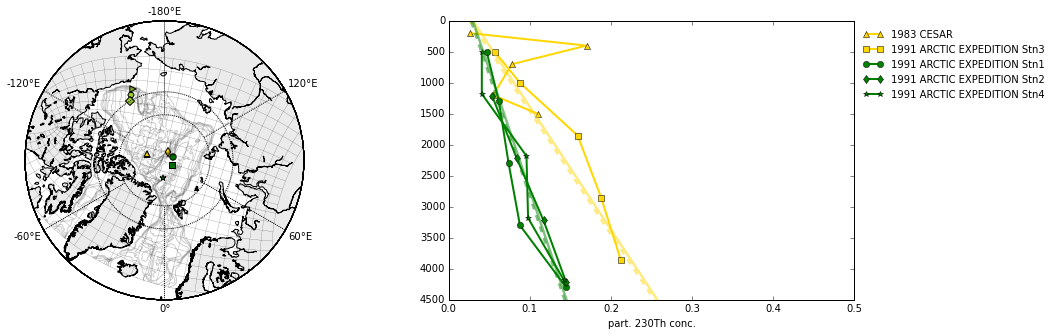

In [11]:
ax = plt.figure(1,figsize=(16,5))

# draw map
ax = plt.subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round='True')

i=0
for j in ([0,5,6,7,8,11,12,13]):
    data=pd.read_csv(nc_filename_[j])
    lon = data['long.'];
    lat = data['lat.'];
    if j<12:
        name= data['name'][0];  
    y_lon, yy_lat = m(lon[0], lat[0])
    m.scatter(y_lon,yy_lat,c=col[j],marker=mark[i],s=40,label=name)
    i+=1

#draw basemap
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[0, 0, 0, 0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[1, 1, 1, 1])
x_lon, y_lat = m(nav_lon[:], nav_lat[:])
m.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='black',linewidth=0.2,alpha=0.7)
m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.2)



#read data and fit
ax = plt.subplot(1,2,2)
i=0

#comnine yellow stations
err_=[];x_=[];y_=[]

for j in ([0,7]):
    if j ==0:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values[2:];# 2:not to read the data above 500m
        x=data['230Th part.'][2:]
        err =data['Th_part_err'][2:]
    else:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values[1:];# 1: same . read data below 500m
        x=data['230Th part.'][1:]
        err =data['Th_part_err'][1:]
    
    err=np.ma.masked_where(x<=0,err)
    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,color=col[j],marker=mark[i],label=name)
    i+=1
    
    
    for num in range (len(x)):
        err_.append(err[num])
        x_.append(x[num])
        y_.append(y[num])
        
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_);x_=np.array(x_);y_=np.array(y_)

#fit and plot
mywls = sm.WLS(x_, y2,weights=1./err_**2).fit()
plt.plot([0, 1.4],[0, 1.4]/mywls.params[0]-mywls.params[1]/mywls.params[0], \
         '--.',c=col[j],linewidth=2.5,alpha=0.5)

s=0.0267/mywls.params[0]
print 'Yellow     :',s,s/3

#print analytical solu.
conc1=(Q/s)*np.array([0,5000])+0.03
#conc2=conc1[-1]+(Q/s)*np.array([500-500,5000-500])
plt.plot(conc1,[0, 5000], \
         '-',c=col[j],linewidth=2.5,alpha=0.5)
#plt.plot(conc2,[500, 5000], \
#         '-',c=col[j],linewidth=2.5,alpha=0.5)



##============================
# combine green stations
err_=[];x_=[];y_=[]

for j in ([5,6,8]):
    if j==8:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values[1:];
        x=data['230Th part.'][1:]
        err =data['Th_part_err']
    else:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values;
        x=data['230Th part.']
        err =data['Th_part_err']
    
    err=np.ma.masked_where(x<=0,err)
    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,color=col[j],marker=mark[i],label=name)
    i+=1
    
    
    for num in range (len(x)):
        err_.append(err[num])
        x_.append(x[num])
        y_.append(y[num])
        
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_);x_=np.array(x_);y_=np.array(y_)


#fit and plot
mywls = sm.WLS(x_, y2,weights=1./err_**2).fit()
plt.plot([0, 1.4],[0, 1.4]/mywls.params[0]-mywls.params[1]/mywls.params[0], \
         '--.',c=col[j],linewidth=2.5,alpha=0.5)

s_=0.0267/mywls.params[0]
print 'Green      :',s_,s_/3
     

#print analytical solu.
conc1=(Q/s_)*np.array([0,5000])+0.03
#conc2=conc1[-1]+(Q/s_)*np.array([500-500,5000-500])
plt.plot(conc1,[0, 5000], \
         '-',c=col[j],linewidth=2.5,alpha=0.5)
#plt.plot(conc2,[500, 5000], \
#         '-',c=col[j],linewidth=2.5,alpha=0.5)



plt.xlim(0,0.5);plt.ylim(0,4500);plt.gca().invert_yaxis();
#label
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1),frameon=False)
plt.xlabel('part. 230Th conc.');plt.show()

Yellow:      k 0.101437832657 k_1 0.5 Q/k 0.263215402977
Green:     k 0.152916198326 k_1 0.5 Q/k 0.1746054394


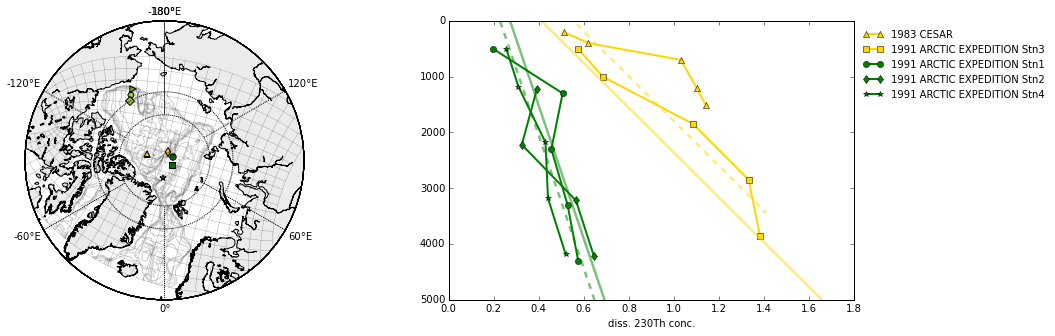

In [12]:
ax = plt.figure(1,figsize=(16,5))
ax = plt.subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round='True')
col=['gold','purple','purple','purple','purple','g','g','gold','g','purple','purple',\
     'yellowgreen','yellowgreen','yellowgreen']
mark=['^','s','o','d','*','H','D','>']

i=0
# 1983,1991
for j in ([0,5,6,7,8,11,12,13]):
    data=pd.read_csv(nc_filename_[j])
    lon = data['long.'];
    lat = data['lat.'];
    if j<12:
        name= data['name'][0];  
    y_lon, yy_lat = m(lon[0], lat[0])
    m.scatter(y_lon,yy_lat,c=col[j],marker=mark[i],s=40,label=name)
    i+=1
        

#draw basemap
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[0, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,60.),labels=[1, 1, 1, 1])
x_lon, y_lat = m(nav_lon[:], nav_lat[:])
m.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='black',linewidth=0.2,alpha=0.7)
m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.2)


ax = plt.subplot(1,2,2)
#1983,1991
i=0

#===============================================

#combine yellow station profiles

err_=[];x_=[];y_=[]


for j in ([0,7]):
    if j ==0:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values[2:];
        x=data['230Th diss.'][2:]
        err =data['Th_diss_err'][2:]
    else:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values[1:];
        x=data['230Th diss.'][1:]#+data['230Th diss.'];
        err =data['Th_diss_err'][1:]
    
    err=np.ma.masked_where(x<=0,err)
    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,color=col[j],marker=mark[i],label=name)
    i+=1
    
    
    for num in range (len(x)):
        err_.append(err[num])
        x_.append(x[num])
        y_.append(y[num])
        
        
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_);x_=np.array(x_);y_=np.array(y_)

mywls = sm.WLS(x_, y2,weights=1./err_**2).fit()
plt.plot([0, 1.4],[0, 1.4]/mywls.params[0]-mywls.params[1]/mywls.params[0], \
         '--.',c=col[j],linewidth=2.5,alpha=0.5)


a=mywls.params[0] #slope
b=mywls.params[1] #cons.  
Q= 0.0267
Jvalue_=0.5#0.3
Kvalue=Q/s*Jvalue_/a

#print analytical solu.
conc1=Q/Kvalue+Jvalue_/Kvalue*((Q/s)*np.array([0,5000])+0.03)
#conc2=conc1[-1]+Jvalue_/Kvalue*(Q/s)*np.array([500-500,5000-500])
plt.plot(conc1,[0, 5000], \
         '-',c=col[j],linewidth=2.5,alpha=0.5)
#plt.plot(conc2,[500, 5000], \
#         '-',c=col[j],linewidth=2.5,alpha=0.5)





print 'Yellow:      k',Kvalue,'k_1',Jvalue_,'Q/k',Q/Kvalue
    
#====================================

#combine green stations

err_=[];x_=[];y_=[]

for j in ([5,6,8]):
    if j==8:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values[1:];
        x=data['230Th diss.'][1:]
        err =data['Th_diss_err']
    else:
        data=pd.read_csv(nc_filename_[j])
        y= data['depth'].values;
        x=data['230Th diss.']#+data['230Th diss.'];
        err =data['Th_diss_err']
    
    err=np.ma.masked_where(x<=0,err)
    x=np.ma.masked_where(y<=0,x)
    y=np.ma.masked_where(y<=0,y) 
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    name= data['name'][0];    
    plt.plot(x,y,'-o',lw=2,color=col[j],marker=mark[i],label=name)
    i+=1
    
    
    for num in range (len(x)):
        err_.append(err[num])
        x_.append(x[num])
        y_.append(y[num])
        
        
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_);x_=np.array(x_);y_=np.array(y_)

# fit and plot
mywls = sm.WLS(x_, y2,weights=1./err_**2).fit()

plt.plot([0, 1.4],[0, 1.4]/mywls.params[0]-mywls.params[1]/mywls.params[0], \
         '--.',c=col[j],linewidth=2.5,alpha=0.5)

a=mywls.params[0] #slope
b=mywls.params[1] #cons.     

Kvalue_=Q/s_*Jvalue_/a

#print analytical solu.
conc1=Q/Kvalue_+Jvalue_/Kvalue_*((Q/s_)*np.array([0,5000])+0.03)
#conc2=conc1[-1]+Jvalue_/Kvalue_*(Q/s_)*np.array([500-500,5000-500])
plt.plot(conc1,[0, 5000], \
         '-',c=col[j],linewidth=2.5,alpha=0.5)
#plt.plot(conc2,[500, 5000], \
#         '-',c=col[j],linewidth=2.5,alpha=0.5)





print 'Green:     k',Kvalue_,'k_1',Jvalue_,'Q/k',Q/Kvalue_



plt.ylim(0,5000);plt.gca().invert_yaxis()
#label
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1),frameon=False)
plt.xlabel('diss. 230Th conc.');plt.show()

In [14]:
# fit with ice (NASA's algorithm)
#ice=[0.923636,0.35]   #NASA

#bootstrap ice
ice=[0.996364,0.477273] 
k=[Kvalue,Kvalue_]
s=[s,s_]

In [15]:
#add intercept
ice_ = sm.add_constant(ice,prepend=False)

#fit
paraS=sm.WLS(s,ice_).fit()
paraK=sm.WLS(k,ice_).fit()

[0 1] [ 1513.80121326   525.11301557] -988.68819769


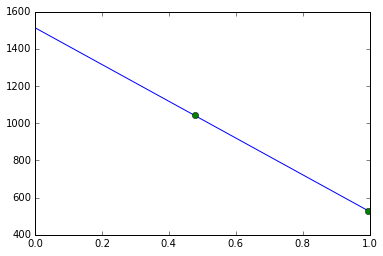

In [38]:
# s and ice
x=np.array([0,1])
yS=x*paraS.params[0]+paraS.params[1]
print x,yS,yS[1]-yS[0]
plt.plot(x,yS)
plt.plot(np.array(ice), np.array(s), 'o')

[0 1] [ 0.20024746  0.10107725] -0.0991702142174


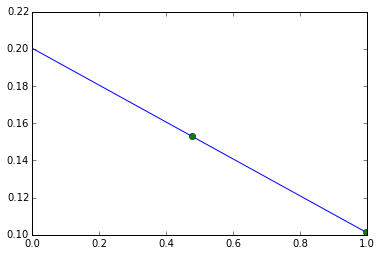

In [39]:
#k and ice
yK=x*paraK.params[0]+paraK.params[1]
print x,yK,yK[1]-yK[0]
plt.plot(x,yK)
plt.plot(np.array(ice), np.array(k), 'o')

In [17]:
print k[1]/0.5,k[0]/0.5,0.2/0.5

0.305832396651 0.202875665315 0.4


In [7]:
for j in ([0,5,6,7,8]):
    data=pd.read_csv(nc_filename_[j])
    y= data['depth'].values;
    x=data['230Th part.']/data['230Th diss.'];
    print x

0   -38.457692
1     0.063158
2     0.052941
3     0.274194
4     0.075728
5     0.050000
6     0.096491
dtype: float64
0    0.238579
1    0.122530
2    0.162281
3    0.166667
4    0.252174
dtype: float64
0    0.137755
1    0.258462
2    0.207080
3    0.224806
dtype: float64
0    0.952381
1    0.099303
2    0.128655
3    0.146544
4    0.141247
5    0.153512
dtype: float64
0    0.127119
1    0.160156
2    0.132258
3    0.223256
4    0.222222
5    0.273603
dtype: float64
